In [1]:
!pip install tensorflow tensorflow_addons tensorflow_datasets tensorflow_hub numpy matplotlib seaborn sklearn

     |████████████████████████████████| 1.1 MB 4.5 MB/s 
     |████████████████████████████████| 462 kB 41.6 MB/s 


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

In [3]:
!pip check

nbclient 0.6.0 has requirement jupyter-client>=6.1.5, but you have jupyter-client 5.3.5.
datascience 0.10.6 has requirement folium==0.2.1, but you have folium 0.8.3.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9.


In [4]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteATJ222/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [5]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

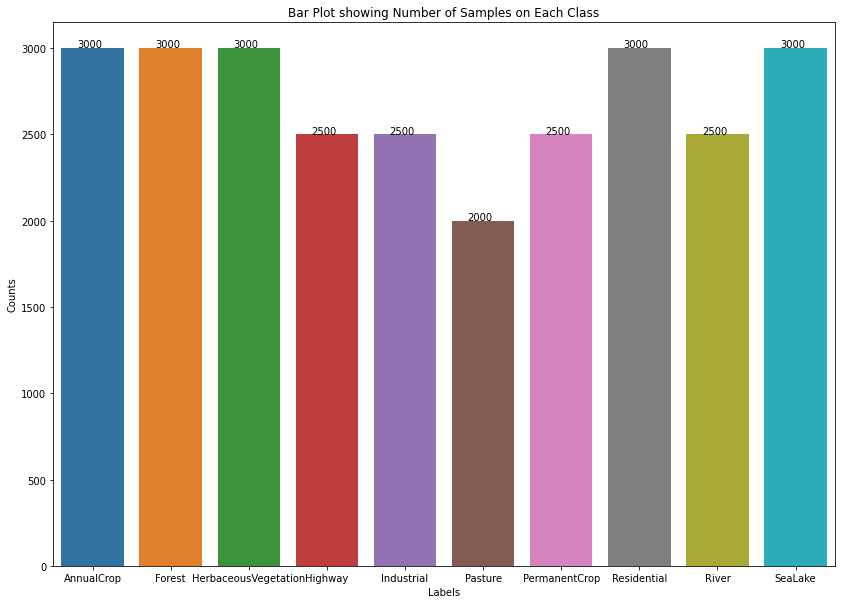

In [6]:
# make a plot for number of samples on each class
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32), 
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax) 
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [7]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [8]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [9]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [10]:
# take the first batch of the training set
batch = next(iter(train_ds))

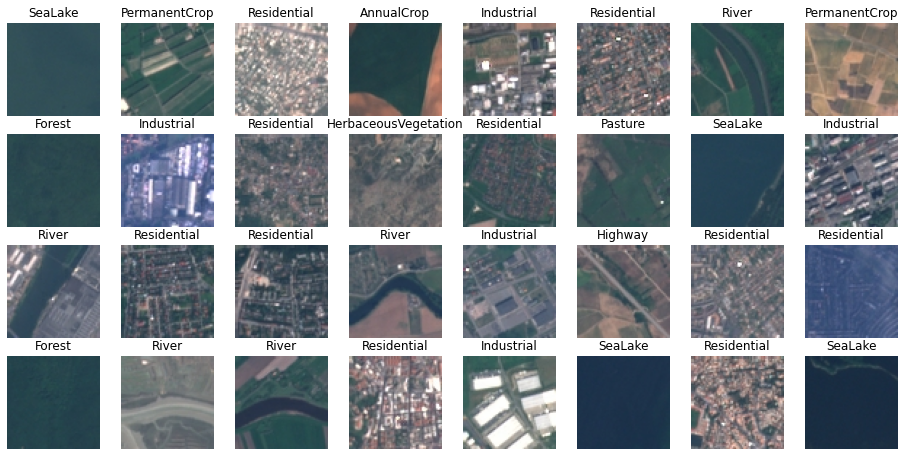

In [11]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

In [12]:
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [13]:
m = tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])
# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])
m.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

In [14]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              117746848 
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 117,759,658
Trainable params: 117,247,082
Non-trainable params: 512,576
_________________________________________________________________


In [15]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [16]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [17]:
# train the model
history = m.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=5, 
    callbacks=[model_checkpoint]
)

Epoch 1/5
253/253 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8843 - f1_score: 0.8815
Epoch 1: val_loss improved from inf to 0.27107, saving model to results/satellite-classification.h5
253/253 [==============================] - 308s 967ms/step - loss: 0.3798 - accuracy: 0.8843 - f1_score: 0.8815 - val_loss: 0.2711 - val_accuracy: 0.9148 - val_f1_score: 0.9146
Epoch 2/5
253/253 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9554 - f1_score: 0.9545
Epoch 2: val_loss improved from 0.27107 to 0.12836, saving model to results/satellite-classification.h5
253/253 [==============================] - 256s 1s/step - loss: 0.1428 - accuracy: 0.9554 - f1_score: 0.9545 - val_loss: 0.1284 - val_accuracy: 0.9615 - val_f1_score: 0.9610
Epoch 3/5
253/253 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9644 - f1_score: 0.9634
Epoch 3: val_loss did not improve from 0.12836
253/253 [==============================] - 232s 917ms/st

In [18]:
# load the best weights
m.load_weights(model_path)

In [19]:
# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)

In [20]:
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)

images.shape: (5400, 64, 64, 3)


In [21]:
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

labels.shape: (5400,)


In [22]:
# feed the images to get predictions
predictions = m.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

predictions.shape: (5400,)


In [23]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.9661111
F1 Score: 0.9646823754334479


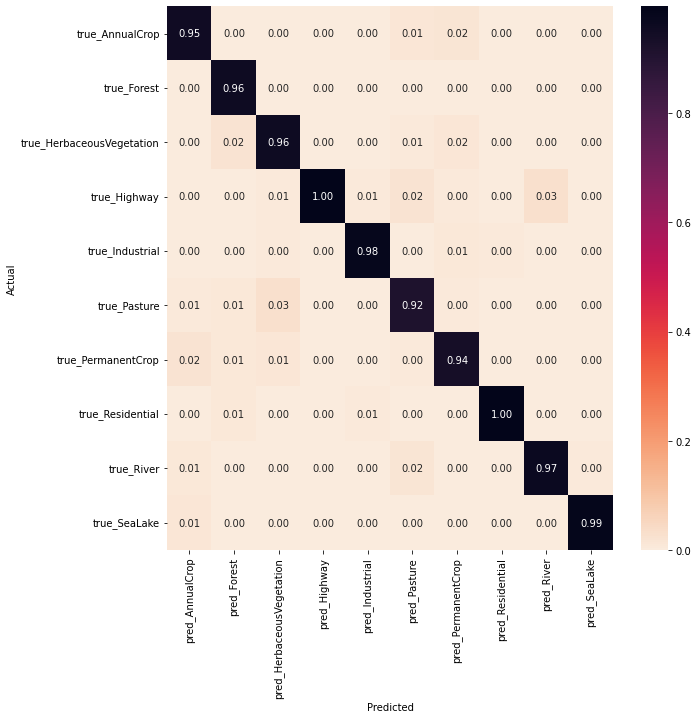

In [24]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', 
            xticklabels=[f"pred_{c}" for c in class_names], 
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

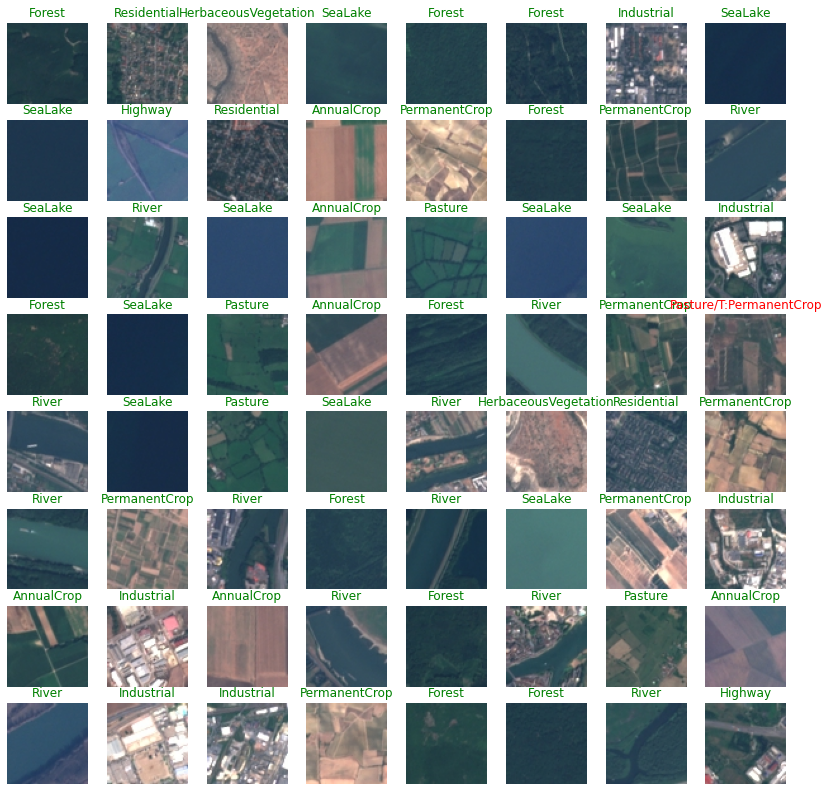

In [ ]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()